### Исследование данных датасетов

![1](./_PPG_Signal.png)

# MAUS: A Dataset for Mental Workload Assessment on N-back task Using Wearable Sensor

The MAUS dataset focused on collecting easy-acquired physiological signals under different mental demand conditions. We used the N-back task to stimuli different mental workload statuses. This dataset can help in developing a mental workload assessment system based on wearable device, especially for that PPG-based system. MAUS dataset provides ECG, Fingertip-PPG, Wrist-PPG, and GSR signal. User can make their own comparison between Fingertip-PPG and Wrist-PPG. Some study can be carried out in this dataset
In brief, each of 22 persons (2 females) recorded in the dataset is represented with a 35-minutes recording of physiological signals (ECG, Fingertip-PPG, Wrist-PPG, and GSR).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, find_peaks
import heartpy as hp

from pathlib import Path

plt.rcParams['figure.figsize'] = (16, 6)

### Инфа по поводу данных датасета, содержания, структуры файлов…

**— см. в Maus_Documentation.pdf!!!**

Если вкратце:
- В Data для каждого субъекта есть своя отдельная папка, в каждой их них ещё по 2 папки:
    - IBI_sequence содержит данные интервалов между ударами сердца (RR-интервалы) во время отдыха (rest_№СЕГМ.csv) и прохождения испытания (trail_№ИСП_№СЕГМ.csv). Все данные (зачем-то) поделены ровно на 3 сегмента, для получения полных данных за конкретный период надо их сконкатенировать.
    - Raw_Data содержит, внезапно, сырые данные! Нас тут больше всего интересуют pixart.csv и pixart_resting.csv — замеры PPG на запястье в покое во время прохождения испытаний соответственно. Также есть данные ECG, GSR и PPG — но только при прохождении испытаний, без состояния покоя.
- В Subjective_rating лежат отзывы самих субъектов на вопросы по оценке сложности (NASA_TLX.csv) и шкале качества сна (PSQI.csv). Нам эти данные, думаю, особо не нужны, хотяяя оценки конгитивной нагрузки можно попробовать сопоставить с HRV для оценки субъективного восприятия стресса.
- У данных PPG на запястье частота снятия 100 Гц, у данных PPG на руке — 256 Гц!

![2](./MAUS_структура_иссл-я.png)

---

### Инфа из гптшки, что можно получить на основе IBI:

**1. Частота сердечных сокращений (ЧСС, HR, Heart Rate)**
   - ЧСС вычисляется на основе **интервалов между ударами сердца (IBI)**, которые есть в файлах `rest_#.csv` и `trial_#_##.csv`.  
   - Формула: $ HR = \frac{60}{IBI} $ (где `IBI` в секундах, результат в ударах в минуту).  

**2. Вариабельность сердечного ритма (ВСР, HRV, Heart Rate Variability)**
   ВСР характеризует адаптационные способности организма и уровень стресса. Можно рассчитать:  
   - **SDNN** (Стандартное отклонение IBI) — общий показатель вариабельности.  
   - **RMSSD** (Среднеквадратичное отклонение разности соседних IBI) — показатель активности парасимпатической нервной системы.  
   - **pNN50** (процент IBI, отличающихся на более чем 50 мс) — показатель стрессоустойчивости.  

   Вариабельность ЧСС снижается при высоком стрессе.  

**3. Амплитуда и форма PPG-сигнала**  
   Эти характеристики можно извлечь из сырых данных `pixart.csv` и `pixart_resting.csv`:  
   - Усреднённая амплитуда отражает уровень кровенаполнения сосудов.  
   - Форма сигнала (его производные, время нарастания и спада) даёт информацию о сосудистой активности.  

**4. Спектральные характеристики (анализ с помощью Фурье или вейвлет-преобразования)**  
   Применив **БПФ (быстрое преобразование Фурье, FFT)** или **вейвлет-анализ**, можно выделить частотные компоненты в PPG и HRV:  
   - **VLF (0.003–0.04 Гц)** — медленные изменения ЧСС, связанные с гормональной регуляцией.  
   - **LF (0.04–0.15 Гц)** — влияние симпатической и парасимпатической нервных систем.  
   - **HF (0.15–0.4 Гц)** — влияние дыхания, показывает уровень релаксации.  

   Отношение **LF/HF** часто используется как показатель стресса (чем выше, тем больше симпатический тонус, связанный с напряжением).  

**5. Дополнительные метрики для анализа психоэмоционального состояния**
   - **Пульсовой транзитный интервал (PTT)** — задержка между R-зубцом ЭКГ и пиком PPG, может отражать артериальное давление.  
   - **Baroreflex Sensitivity (BRS)** — анализирует связь между ЧСС и кровяным давлением.  

**Вывод**  
Да, MAUS-дataset содержит достаточно данных для анализа психоэмоционального состояния, включая стресс, утомление и когнитивную нагрузку. Для этого можно использовать:  
- **HR, HRV, SDNN, RMSSD, pNN50** (по данным IBI).  
- **Фурье- и вейвлет-анализ** (для спектральных характеристик).  
- **Анализ формы и амплитуды PPG** (для оценки тонуса сосудов).  

---

### Попробуем визуализирвовать данные для одного из поциентафф

In [1]:
# От 1 до 22
subject_no = 6

In [2]:
subject_no = f'00{subject_no}' if (subject_no < 10) else f'0{subject_no}'

path_ibi = Path.cwd() / 'DATASETS' / 'MAUS' / 'Data' / 'IBI_sequence' / subject_no
path_raw = Path.cwd() / 'DATASETS' / 'MAUS' / 'Data' / 'Raw_data' / subject_no

# list(path_ibi.iterdir())
# list(path_raw.iterdir())

NameError: name 'Path' is not defined

In [ ]:
ibi_files_rest = []
ibi_files_trial = []
ibi_files_trialpeak = []

for fname in list(path_ibi.iterdir()):
    if "rest" in str(fname):
        ibi_files_rest.append(fname)
    elif "trial" in str(fname):
        if "peak" in str(fname):
            ibi_files_trialpeak.append(fname)
        else:
            ibi_files_trial.append(fname)

# print(ibi_files_trialpeak)

In [ ]:
# От 1 до 6
trial_no = 3

### Сперва — данные RR (IBI_sequence)

In [ ]:
df_trial_example = pd.DataFrame()

for i in range(trial_no*3, (trial_no+1)*3):
    df_trial_example_segment = pd.read_csv(ibi_files_trial[i])
    df_trial_example = pd.concat([df_trial_example, df_trial_example_segment], axis=0, ignore_index=True)

df_trial_example

,RRI_inf,PPI_inf,PPI_pix,label
0,839.84375,839.84375,829.268293,0.0
1,875.00000,875.00000,878.048780,0.0
2,863.28125,871.09375,878.048780,0.0
3,812.50000,816.40625,809.756098,0.0
4,847.65625,843.75000,839.024390,0.0
...,...,...,...,...
352,976.56250,976.56250,985.365854,0.0
353,933.59375,933.59375,936.585366,0.0
354,972.65625,968.75000,965.853659,0.0
355,964.84375,972.65625,956.097561,0.0


**Здесь:**
- RRI_inf — данные RR-интервалов **с ECG**
- PPI_inf — данные RR-интервалов **с PPG на пальце**
- PPI_pix — данные RR-интервалов **с PPG на запястье**
- label — хз что он означает, почти всегда =0

Если чо, в rest структура данных полностью аналогичная)

По идее, нам кагбэ нужны данные PPI_pix, но в них, хотя и редко, но встречаются выбросы, поэтому может лучше взять PPI_inf?

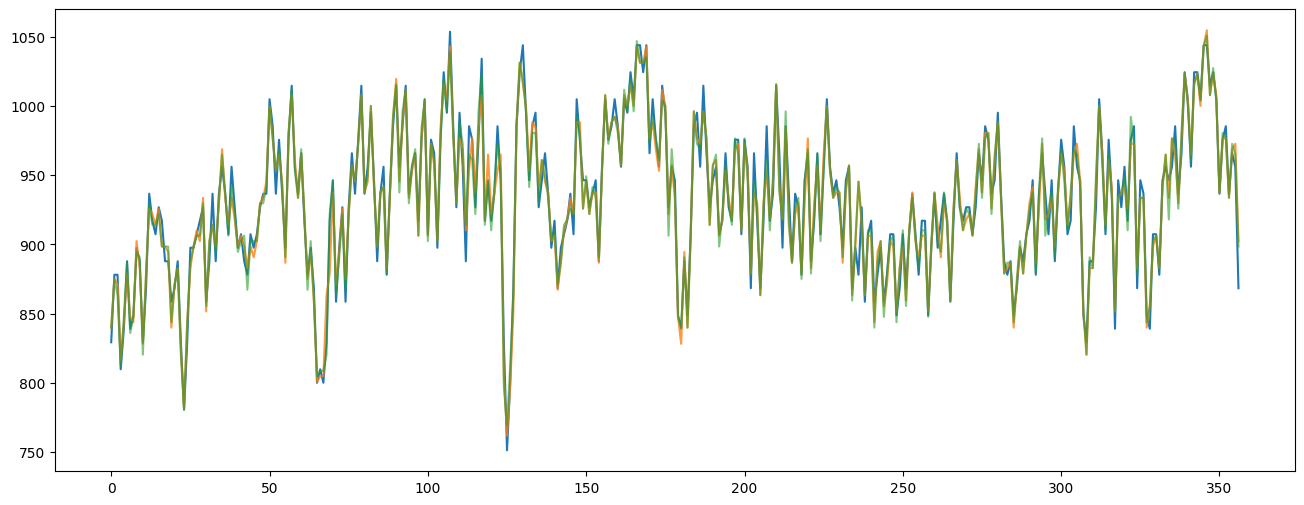

In [ ]:
# time_example = np.arange(0, ...) # А что у нас, собственно, будет для IBI временем?

plt.plot(df_trial_example["PPI_pix"], alpha=1.0)
plt.plot(df_trial_example["PPI_inf"], alpha=0.8)
plt.plot(df_trial_example["RRI_inf"], alpha=0.6)
plt.show()

In [ ]:
df_trialpeak_example = pd.DataFrame()

for i in range(trial_no*3, (trial_no+1)*3):
    df_trialpeak_example_segment = pd.read_csv(ibi_files_trialpeak[i])
    df_trialpeak_example = pd.concat([df_trialpeak_example, df_trialpeak_example_segment], axis=0, ignore_index=True)

df_trialpeak_example

,valley_location,PPI
0,385.0,0.000000
1,485.0,975.609756
2,581.0,936.585366
3,679.0,956.097561
4,772.0,907.317073
...,...,...
363,11397.0,809.756098
364,11484.0,848.780488
365,11579.0,926.829268
366,11668.0,868.292683


**Здесь:**
- valley_location — индекс сигнала, соответствующий локальному минимуму
- PPI — расстояние между этим и предыдущим пиками

АХТУНГ — оба параметра высчитываются не для всего датасета, а только для конкретного сегмента. То есть при конкате данных нужно прибавить положение последнего прошлого сегмента ко всем новым, и перерасчитать выпавшие PPI!

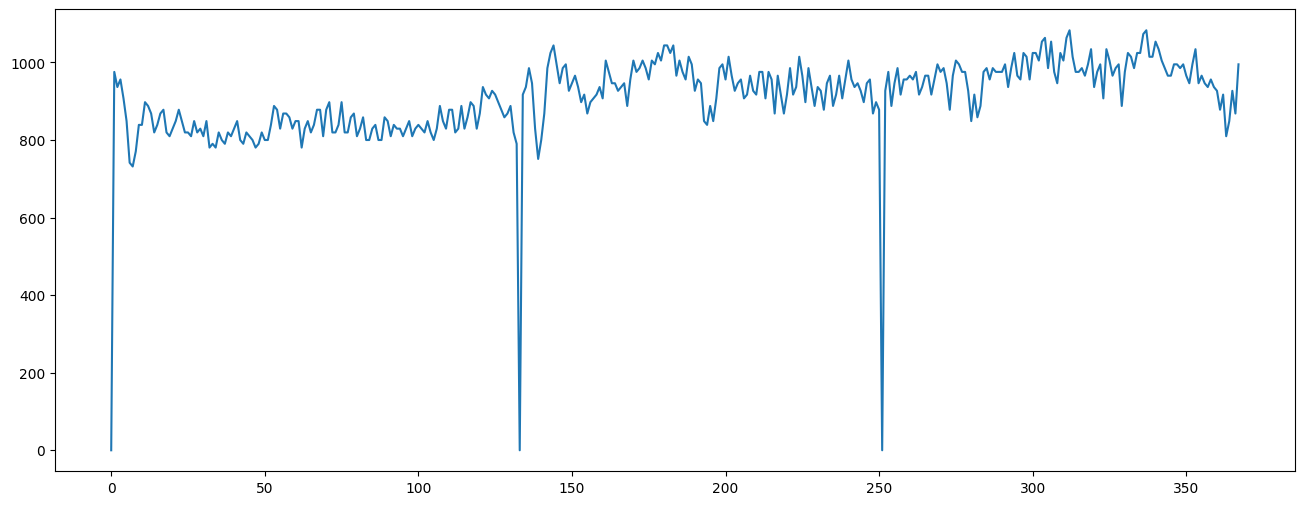

In [ ]:
# time_example = np.arange(0, ...) # А что у нас, собственно, будет для IBI временем?

plt.plot(df_trialpeak_example["PPI"])
plt.show()

### Теперь — сырые данные (Raw_data)

In [ ]:
df_ppg_wrist_trial = pd.read_csv(path_raw / 'pixart.csv')
df_ppg_wrist_trial.head()

,Trial 1:0back,Trial 2:2back,Trial 3:3back,Trial 4:2back,Trial 5:3back,Trial 6:0back
0,-1878283.0,-1724871.0,-1578345.0,-1596569.0,-1617505.0,-1568195.0
1,-1878105.0,-1724575.0,-1579037.0,-1596451.0,-1617781.0,-1568491.0
2,-1878007.0,-1725327.0,-1579255.0,-1597103.0,-1618137.0,-1568393.0
3,-1877313.0,-1724811.0,-1578939.0,-1597301.0,-1618593.0,-1568313.0
4,-1878105.0,-1725089.0,-1578839.0,-1598013.0,-1619761.0,-1569163.0


In [ ]:
df_ppg_finger_trial = pd.read_csv(path_raw / 'inf_ppg.csv')
df_ppg_finger_trial.head()

,Trial 1:0back,Trial 2:2back,Trial 3:3back,Trial 4:2back,Trial 5:3back,Trial 6:0back
0,36.554,32.175,34.637,35.987,36.179,34.672
1,36.525,32.143,34.586,36.018,36.430,34.646
2,36.496,32.111,34.538,36.048,36.670,34.620
3,36.469,32.078,34.492,36.075,36.899,34.593
4,36.442,32.044,34.448,36.100,37.113,34.564


В ..._rest структура аналогичная, только там лишь одна колонка, с названием "Resting"

**Поглядаем на визуализации:**

In [ ]:
ppg_example_wrist = df_ppg_wrist_trial[df_ppg_wrist_trial.columns[trial_no-1]]
ppg_example_finger = df_ppg_finger_trial[df_ppg_finger_trial.columns[trial_no-1]]

# peaks_cutoff = list(
#     filter(lambda peak: peak < 1200, df_trialpeak_example["valley_location"])
# )

ppg_example_wrist_iterp = np.interp(
    np.linspace(0, 1, len(ppg_example_finger)),
    np.linspace(0, 1, len(ppg_example_wrist)),
    ppg_example_wrist
)

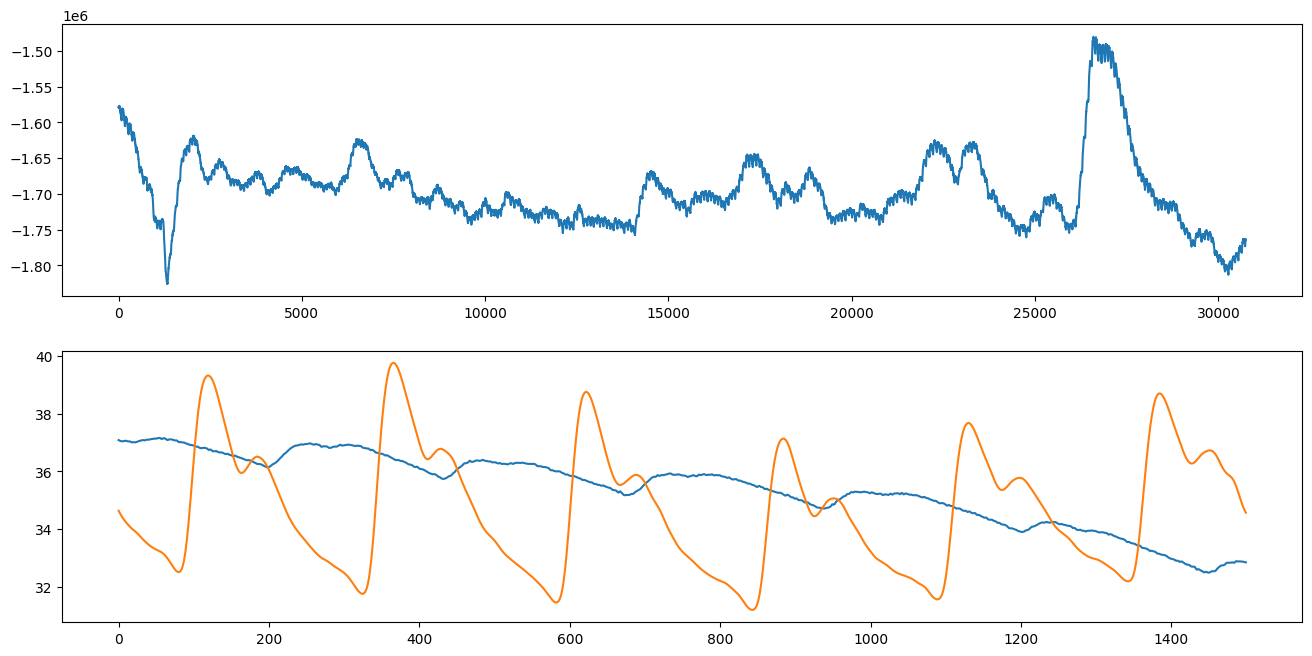

In [ ]:
plt.figure(figsize=(16, 12))
plt.subplot(311)
plt.plot(ppg_example_wrist)
plt.subplot(312)
plt.plot(ppg_example_wrist_iterp[0:int(len(ppg_example_wrist_iterp) / 256*5)] / 20000 + 116)
plt.plot(ppg_example_finger[0:int(len(ppg_example_finger) / 256*5)])
# plt.subplot(313)
# plt.plot(ppg_example_wrist[0:int(len(ppg_example_wrist))])
# plt.plot(peaks_cutoff, ppg_example_wrist[peaks_cutoff], "ro")
plt.show()

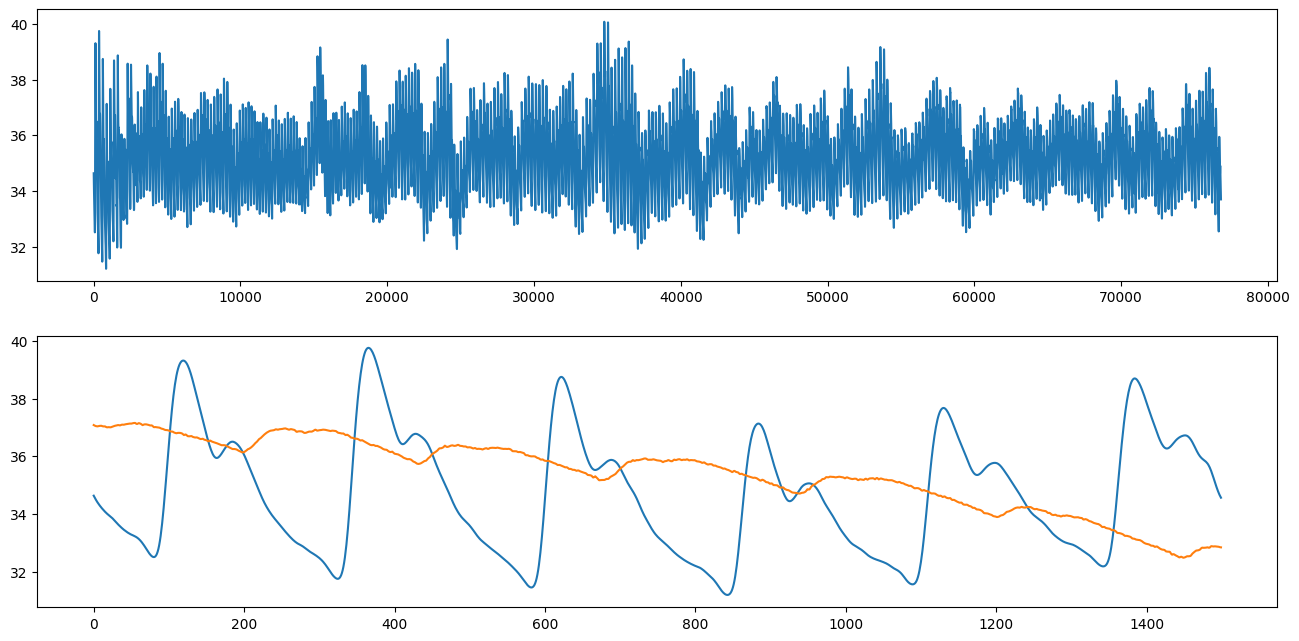

In [ ]:
plt.figure(figsize=(16, 12))
plt.subplot(311)
plt.plot(ppg_example_finger)
plt.subplot(312)
plt.plot(ppg_example_finger[0:int(len(ppg_example_finger) / 256*5)])
plt.plot(ppg_example_wrist_iterp[0:int(len(ppg_example_wrist_iterp) / 256*5)] / 20000 + 116)
# plt.subplot(313)
# plt.plot(ppg_example_wrist[0:int(len(ppg_example_wrist))])
# plt.plot(peaks_cutoff, ppg_example_wrist[peaks_cutoff], "ro")
plt.show()

**Простая обработка через полосовой фильтр**

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def detect_r_peaks(ppg_signal, fs, lowcut=0.5, highcut=10.0):
    # Создаём и применяем полосовой фильтр
    b, a = butter_bandpass(lowcut, highcut, fs)
    filtered_signal = filtfilt(b, a, ppg_signal)

    peaks, _ = find_peaks(
        filtered_signal,
        distance=fs * 0.5,
        height=np.mean(filtered_signal)
    )
    
    return peaks, filtered_signal

def compute_rr_dist(r_peaks, fs):
    # Переводим расстояния сигнала в секунды
    rr_intervals = np.diff(r_peaks) / fs
    return rr_intervals

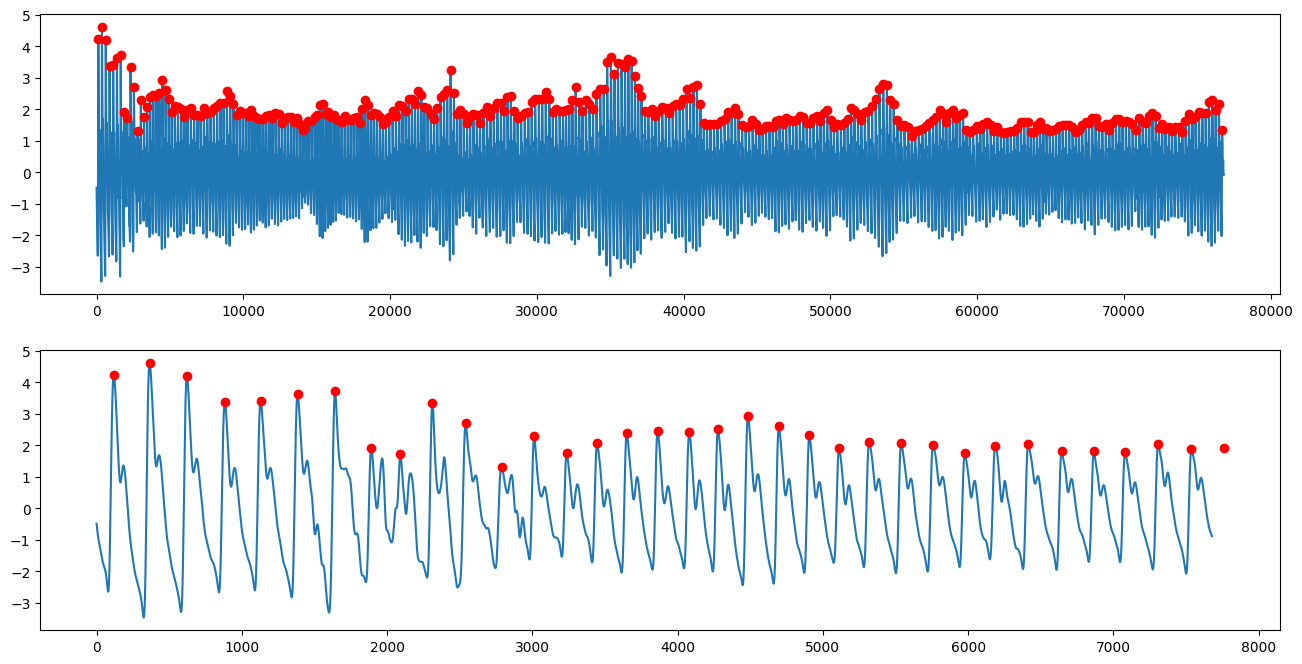

RR-расстояния между пиками, в секундах: [0.96484375 1.00390625 1.01953125 0.9609375  0.99609375 1.0078125
 0.97265625 0.78515625 0.859375   0.89453125 0.96875    0.875
 0.875      0.81640625 0.796875   0.83203125 0.8515625  0.7734375
 0.8046875  0.83203125 0.8203125  0.796875   0.8125     0.859375
 0.85546875 0.85546875 0.8203125  0.88671875 0.89453125 0.8671875
 0.83984375 0.890625   0.89453125 0.87109375 0.86328125 0.88671875
 0.890625   0.8359375  0.8671875  0.890625   0.875      0.828125
 0.8125     0.80859375 0.796875   0.7734375  0.7734375  0.77734375
 0.796875   0.78125    0.76953125 0.796875   0.83203125 0.80859375
 0.83203125 0.82421875 0.8359375  0.78125    0.796875   0.8125
 0.77734375 0.77734375 0.80078125 0.7890625  0.7734375  0.7890625
 0.8203125  0.8046875  0.7734375  0.77734375 0.734375   0.71484375
 0.7109375  0.68359375 0.703125   0.7265625  0.73828125 0.7109375
 0.75       0.8046875  0.78515625 0.7734375  0.80078125 0.78515625
 0.75390625 0.78125    0.76953125 0.7695

In [ ]:
ppg_example_finger_rpeaks, ppg_example_finger_filtered = detect_r_peaks(
    ppg_example_finger, 256
)
ppg_example_finger_rrdist = compute_rr_dist(
    ppg_example_finger_rpeaks, 256
)

plt.figure(figsize=(16, 8))
plt.subplot(211)
plt.plot(ppg_example_finger_filtered)
plt.plot(ppg_example_finger_rpeaks, ppg_example_finger_filtered[ppg_example_finger_rpeaks], "ro")
plt.subplot(212)
plt.plot(ppg_example_finger_filtered[0:int(len(ppg_example_finger_filtered) / 10)])
# plt.plot(ppg_example_finger[0:int(len(ppg_example_finger) / 10)])
plt.plot(ppg_example_finger_rpeaks[0:35], ppg_example_finger_filtered[ppg_example_finger_rpeaks[0:35]], "ro")
plt.show()

print('RR-расстояния между пиками, в секундах:', ppg_example_finger_rrdist)

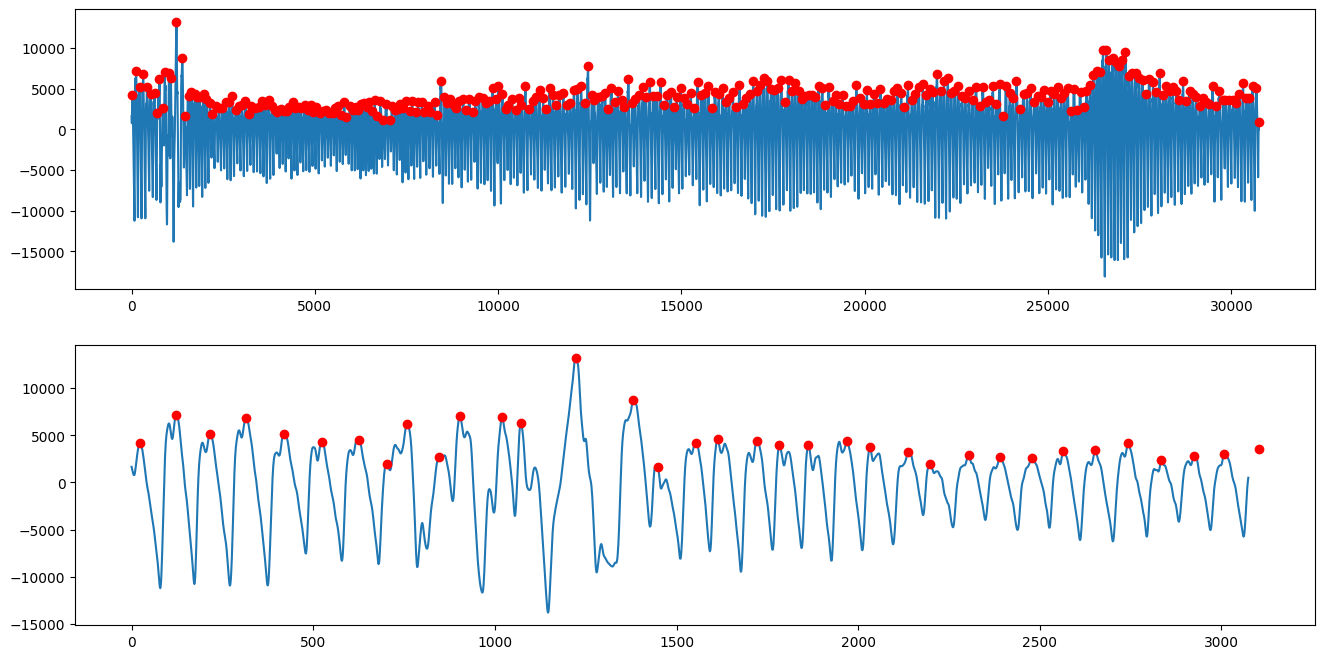

RR-расстояния между пиками, в секундах: [1.   0.93 1.   1.03 1.06 1.02 0.75 0.57 0.88 0.57 1.16 0.51 1.51 1.59
 0.67 1.05 0.6  1.08 0.62 0.8  1.06 0.64 1.05 0.61 1.05 0.87 0.88 0.86
 0.88 0.9  0.92 0.89 0.84 0.95 0.91 0.7  1.09 0.93 0.88 0.86 0.96 0.87
 0.93 0.6  0.99 0.87 0.84 0.59 0.95 0.62 1.02 0.58 1.07 0.76 0.88 0.64
 0.86 1.05 0.63 1.02 0.76 0.93 0.56 0.97 0.65 1.04 0.57 1.05 0.77 0.85
 0.6  0.8  0.75 0.72 0.72 0.7  0.75 0.74 0.77 0.72 0.78 1.04 0.58 0.82
 1.   0.57 0.81 0.8  0.95 0.62 0.96 0.64 1.01 0.68 1.03 0.67 1.14 0.68
 1.13 0.86 0.62 1.05 0.91 0.63 0.87 1.1  0.61 1.06 0.88 0.7  1.03 0.98
 0.94 0.85 0.92 0.95 0.65 1.07 0.98 0.67 1.05 0.9  0.94 0.65 1.09 0.99
 0.95 0.95 0.96 1.01 0.84 0.89 0.92 0.95 0.73 1.2  0.91 0.79 1.13 0.98
 1.02 0.92 0.94 1.05 0.66 1.14 0.94 0.92 0.85 0.66 1.05 0.9  1.   0.67
 1.13 1.04 0.69 1.23 0.95 0.95 0.95 1.07 0.94 1.   0.94 0.74 1.17 0.86
 0.7  1.05 0.91 0.95 0.92 0.97 0.94 1.01 0.92 0.98 0.97 0.88 0.96 1.03
 0.92 0.88 1.04 0.89 0.9  1.01 0.88 0

In [ ]:
ppg_example_wrist_rpeaks, ppg_example_wrist_filtered = detect_r_peaks(
    ppg_example_wrist, 100
)
ppg_example_wrist_rrdist = compute_rr_dist(
    ppg_example_wrist_rpeaks, 100
)

plt.figure(figsize=(16, 8))
plt.subplot(211)
plt.plot(ppg_example_wrist_filtered)
plt.plot(ppg_example_wrist_rpeaks, ppg_example_wrist_filtered[ppg_example_wrist_rpeaks], "ro")
plt.subplot(212)
plt.plot(ppg_example_wrist_filtered[0:int(len(ppg_example_wrist_filtered) / 10)])
# plt.plot(ppg_example_wrist[0:int(len(ppg_example_wrist) / 10)])
plt.plot(ppg_example_wrist_rpeaks[0:35], ppg_example_wrist_filtered[ppg_example_wrist_rpeaks[0:35]], "ro")
plt.show()

print('RR-расстояния между пиками, в секундах:', ppg_example_wrist_rrdist)

**Наконец, попробуем прогнать через HeartPy...**

Увы, для полного датасета, при данном sample rate он выдаёт ошибку, при удвоенном срабатывает, но выдаёт полную чушь. Работает он только для небольших кусочков, да и то иногда почему-то пропускает пики сигнала.

В случае с данными с запястья всё немного печальнее (хотя и намного лучше, чем если подать этот сигнал без обработки), т.к. идёт больше выбросов. А ещё HeartPy зачем-то переворачивает

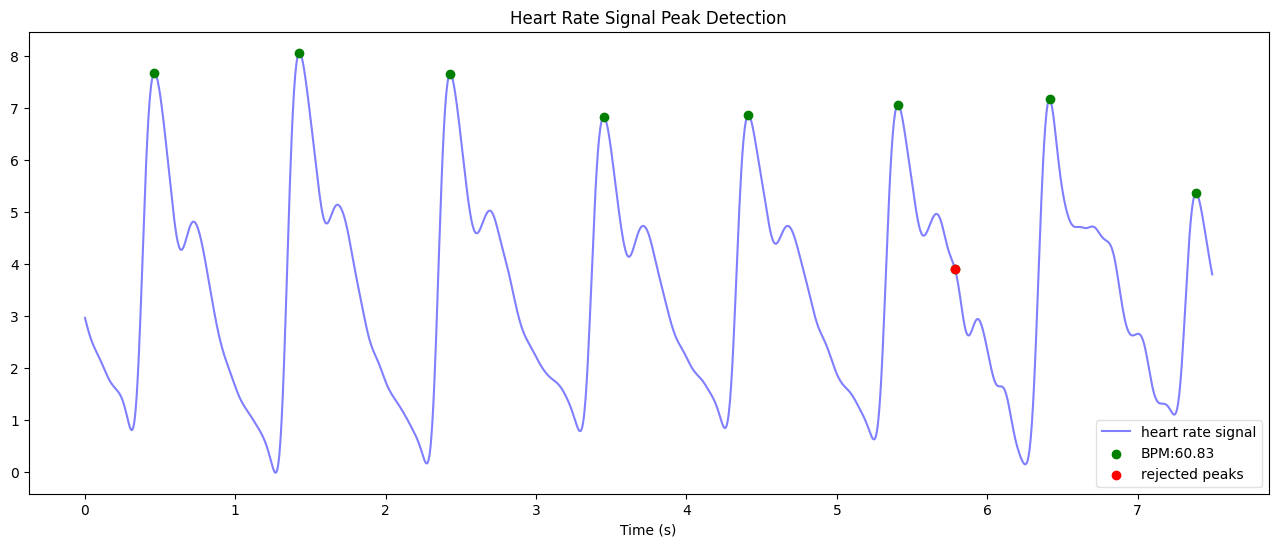

bpm: 60.831683
ibi: 986.328125
sdnn: 21.602422
sdsd: 15.254394
rmssd: 40.122341
pnn20: 0.750000
pnn50: 0.250000
hr_mad: 19.531250
sd1: 27.827748
sd2: 17.740139
s: 1550.904100
sd1/sd2: 1.568632
breathingrate: 0.169090


In [ ]:
wd, m = hp.process(
    ppg_example_finger_filtered[0:int(len(ppg_example_finger_filtered) / 40)],
    sample_rate=256
)

hp.plotter(wd, m)
plt.show()

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

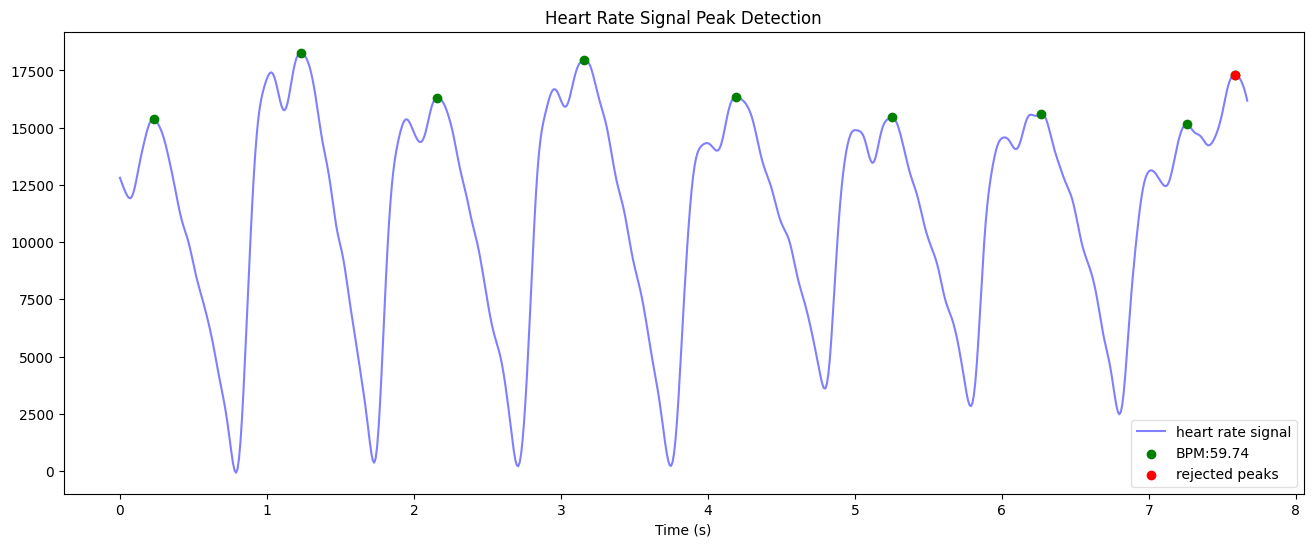

bpm: 59.743954
ibi: 1004.285714
sdnn: 37.361991
sdsd: 18.027756
rmssd: 48.476799
pnn20: 1.000000
pnn50: 0.333333
hr_mad: 20.000000
sd1: 34.258008
sd2: 45.169434
s: 4861.347076
sd1/sd2: 0.758433
breathingrate: 0.142248


In [ ]:
wd, m = hp.process(
    ppg_example_wrist_filtered[0:int(len(ppg_example_wrist_filtered) / 40)],
    sample_rate=100
)

hp.plotter(wd, m)
plt.show()

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

# TODO:

- Соотнести данные IBI и данные PPG запястья (я на самом деле не уверен, что это вообще возможно, значения как будто слишком рандомные и не совпадают, но однозначно стоит попробовать ещё поковыряться)
- На основе данных IBI (либо определённых самостоятельно пиков, если соотнести не получится) и PPG вычислить ВСР, ЧСС, SDNN, LF/HF. Может ещё какие-то признаки на будущее, эти четыре самые важные
- Выполнить дополнительную разметку по необходимости, перепроверить текущие алгоритмы получения данных; подготовить размеченные данные к дальнейшему использованию для обучения и тренировки модели